<a href="https://colab.research.google.com/github/choarauc/pyck/blob/main/7_Pari_selon_proba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

from google.colab import files 
uploaded = files.upload()

Saving df_model.csv to df_model.csv


Import des librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from imblearn.metrics import classification_report_imbalanced

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Import DataFrame pour modélisation
#df = pd.read_csv('//content/drive/Othercomputers/Mon Ordinateur/Datascientest/Projet/données/df_model.csv', index_col=0)

# Import DataFrame pour modélisation
df = pd.read_csv('df_model.csv', index_col=0)

# La saison lue en tant que numérique est remise en chaine de caractère
df['Saison'] = df['Saison'].astype(str)
df_tot=df.copy()


# Sélection des variables

Après maints essais de sélection de variables avec différentes méthodes (SelectKBest, PCA, ...), qui ont donné des scores moins élevés, nous avons tenté plusieurs sélections manuelles en privilégiant les variables avec les coefficients de corrélation les plus élevés (+ ou -) avec le résultat du match.

Voici celle qui a donné les meilleurs résultats :

In [ ]:
# Variables sélectionnées pour la modélisation
xvars = ['Saison','Min_cote_domicile','Min_cote_exterieur','note_def_ext','note_gen_dom','Points_moy_match_saison_dom','Moy_buts_5_matchs_dom',
           'Points_moy_match_saison_ext']

df = df.loc[:, xvars + ["Resultat_match"]]
df['Resultat_match'] = df['Resultat_match'].replace(['H','D','A'], [2, 1,0])

In [ ]:
# Création des dataframes de cible et de données
target = df[['Resultat_match','Saison']]
data = df.loc[:, xvars]

# Remplacement des modalités de target par des nombres pour la modélisation
target['Resultat_match'] = target['Resultat_match'].replace(['H','D','A'], [2, 1,0])

# Création des dataframe d'entrainenemnt et de test : entrainement sur les saison 2015 à 2020 et test sur 2021 (saison non encore terminée)
X_train_=data.loc[data['Saison'] != '2021', :].drop('Saison',axis=1)
X_test_=data.loc[data['Saison'] == '2021', :].drop('Saison',axis=1)
y_train=target.loc[target['Saison'] != '2021', :].drop('Saison',axis=1)
y_test=target.loc[target['Saison'] == '2021', :].drop('Saison',axis=1)
print(X_train_.shape)
print(X_test_.shape)
print(y_train.shape)
print(y_test.shape)

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test_)

y_test=y_test.to_numpy().reshape(220,)
y_train=y_train.to_numpy().reshape(2178,)

(2178, 7)
(220, 7)
(2178, 1)
(220, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Modèle le plus performant

# Gain avec le meilleur modèle (KNN)

Accuracy:  0.5181818181818182
                   pre       rec       spe        f1       geo       iba       sup

          0       0.49      0.41      0.82      0.45      0.58      0.32        66
          1       0.48      0.21      0.91      0.29      0.43      0.17        63
          2       0.54      0.81      0.50      0.65      0.64      0.42        91

avg / total       0.51      0.52      0.71      0.48      0.56      0.32       220



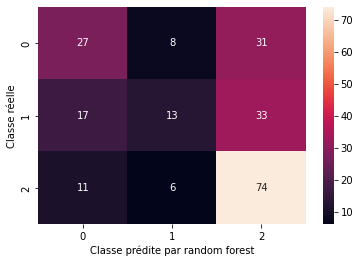

In [ ]:
# On reprend notre modèle KNN
knn = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors= 55, weights= 'uniform')
cv = KFold(n_splits=3, random_state=22 , shuffle = True)

scores = cross_validate(knn, X_train, y_train, cv=cv, scoring=['accuracy','f1_micro', 'f1_macro', 'f1_weighted'])
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_knn, rownames = ['Classe réelle'], colnames = ['Classe prédite par random forest'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_knn));
print(classification_report_imbalanced(y_test, y_pred_knn)) 

Accuracy:  0.5371900826446281


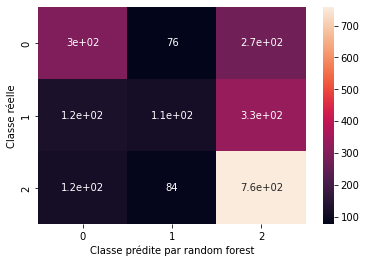

In [ ]:
# On prend aussi les prédictions sur le jeu d'entraînement
y_pred_knn_train = knn.predict(X_train)
confusion_matrix=pd.crosstab(y_train, y_pred_knn_train, rownames = ['Classe réelle'], colnames = ['Classe prédite par random forest'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_train, y_pred_knn_train));

In [ ]:
y_pred_knn_proba = knn.predict_proba(X_test)
y_pred_knn_proba_train = knn.predict_proba(X_train)

In [ ]:
# Proba pour chaque résultat
y_pred_knn_proba = pd.DataFrame(knn.predict_proba(X_test))
y_pred_knn_proba_train = pd.DataFrame(knn.predict_proba(X_train))

y_proba = pd.concat([y_pred_knn_proba_train, y_pred_knn_proba])
y_proba.columns = ['Proba_0','Proba_1','Proba_2']
y_proba.reset_index(inplace=True,drop=True)

# On récupère nos prédictions dans un dataframe
y_pred_knn_df= pd.DataFrame(y_pred_knn)
y_pred_knn_train_df = pd.DataFrame(y_pred_knn_train)

y = pd.concat([y_pred_knn_train_df, y_pred_knn_df])
y.columns = ['Prediction']
y.reset_index(inplace=True,drop=True)

Préparation des données pour le calcul des gains

In [ ]:
# On récupère nos données de départ
df_complet = df_tot.copy()
df_complet['Resultat_match'] = df_complet['Resultat_match'].replace(['H','D','A'], [2, 1,0])
df_complet.reset_index(inplace=True,drop=True)
# Ajout des prédictions faites à partir du meilleur KNN
df_avec_pred = pd.concat([df_complet, y,y_proba],axis=1)
df_avec_pred.head(3)

,Saison,Resultat_match,Moy_cote_domicile,Max_cote_domicile,Min_cote_domicile,Moy_cote_exterieur,Max_cote_exterieur,Min_cote_exterieur,Moy_cote_nul,Max_cote_nul,...,note_mil_ext,note_def_ext,note_gen_ext,Res_an_dernier_A,Res_an_dernier_D,Res_an_dernier_H,Prediction,Proba_0,Proba_1,Proba_2
0,2015,0,6.22,7.00,4.65,1.65,1.75,1.57,3.63,3.8,...,82,82,83,0,0,0,0,0.527273,0.236364,0.236364
1,2015,2,2.56,2.71,2.30,2.97,3.10,2.80,3.01,3.1,...,75,75,75,0,0,0,2,0.272727,0.327273,0.400000
2,2015,0,1.55,1.57,1.50,6.05,6.59,5.50,4.08,4.4,...,71,72,71,0,0,0,2,0.200000,0.218182,0.581818


In [ ]:
df_avec_pred['Prob_bk_0'] = (1/df_avec_pred['Max_cote_exterieur']/(1/df_avec_pred['Max_cote_domicile']+1/df_avec_pred['Max_cote_exterieur']+1/df_avec_pred['Max_cote_nul'])).round(3)
df_avec_pred['Prob_bk_1'] = (1/df_avec_pred['Max_cote_nul']/(1/df_avec_pred['Max_cote_domicile']+1/df_avec_pred['Max_cote_exterieur']+1/df_avec_pred['Max_cote_nul'])).round(3)
df_avec_pred['Prob_bk_2'] = (1/df_avec_pred['Max_cote_domicile']/(1/df_avec_pred['Max_cote_domicile']+1/df_avec_pred['Max_cote_exterieur']+1/df_avec_pred['Max_cote_nul'])).round(3)


In [ ]:
#pari si taux de probabilité > 51%,

taux_proba = 0.4
pari1 = 10
pari2 = 15
pari3 = 20

In [ ]:
# Montant à parier en fonction du resultat 

df_avec_pred['bet_0'] = np.where((df_avec_pred['Proba_0']>df_avec_pred['Prob_bk_0']) & (df_avec_pred['Proba_0']>taux_proba), pari1 , 0)
df_avec_pred['bet_0'] = np.where((df_avec_pred['Proba_0']-df_avec_pred['Prob_bk_0']>0.10) & (df_avec_pred['Proba_0']>taux_proba), pari2 , df_avec_pred['bet_0'])
df_avec_pred['bet_0'] = np.where((df_avec_pred['Proba_0']-df_avec_pred['Prob_bk_0']>0.20) & (df_avec_pred['Proba_0']>taux_proba), pari3 , df_avec_pred['bet_0'])

df_avec_pred['bet_1'] = np.where((df_avec_pred['Proba_1']>df_avec_pred['Prob_bk_1']) & (df_avec_pred['Proba_1']>taux_proba), pari1 , 0)
df_avec_pred['bet_1'] = np.where((df_avec_pred['Proba_1']-df_avec_pred['Prob_bk_1']>0.10) & (df_avec_pred['Proba_1']>taux_proba), pari2 , df_avec_pred['bet_1'])
df_avec_pred['bet_1'] = np.where((df_avec_pred['Proba_1']-df_avec_pred['Prob_bk_1']>0.20) & (df_avec_pred['Proba_1']>taux_proba), pari3 , df_avec_pred['bet_1'])

df_avec_pred['bet_2'] = np.where((df_avec_pred['Proba_2']>df_avec_pred['Prob_bk_2']) & (df_avec_pred['Proba_2']>taux_proba), pari1 , 0)
df_avec_pred['bet_2'] = np.where((df_avec_pred['Proba_2']-df_avec_pred['Prob_bk_2']>0.10) & (df_avec_pred['Proba_2']>taux_proba), pari2 , df_avec_pred['bet_2'])
df_avec_pred['bet_2'] = np.where((df_avec_pred['Proba_2']-df_avec_pred['Prob_bk_2']>0.20) & (df_avec_pred['Proba_2']>taux_proba), pari3 , df_avec_pred['bet_2'])


In [ ]:
# Liste des matchs

matchs = []
#2178
for i in range(2178,2398):
    matchs.extend([i,i,i])

#Liste des résultats
resultats = []
for i in range(2178,2398):
    resultats.extend([2,1,0])

#Montant parié par match et résultat
montants = []
for i in range(2178,2398):
    montants.extend(df_avec_pred.loc[i][['bet_2', 'bet_1', 'bet_0']])


In [ ]:
dic_resultat = {2 : 'Max_cote_domicile', 1: 'Max_cote_nul', 0 : 'Max_cote_exterieur'}

def gain_paris(matchs, resultats, montants):

    benefices = 0
    for match, resultat, montant in zip(matchs, resultats, montants):

        #itération simultanées des éléments des trois listes 
        if df_avec_pred.loc[match]['Resultat_match'] == resultat:

            #bénéfice du pari si le résultat prédit est bon 
            benefice = (df_avec_pred.loc[match][dic_resultat[resultat]] - 1)*montant

        else : benefice = -montant
        #perte du BET si le résultat prédit est faux

        benefices += benefice
        #on rajoute le gains ou la perte au total 

    pourcentage = benefices*100/sum(montants)
    #calcul du pourcentage gagné/perdu 

    return print('Montant parié :', sum(montants)), print('Gains/pertes :', benefices), print('Rendement du modèle :', pourcentage.round(2), ' %')

gain_knn  = gain_paris(matchs, resultats, montants)

Montant parié : 950
Gains/pertes : 238.64999999999998
Rendement du modèle : 25.12  %


In [ ]:
debut_saison_test=2178
# nombre de paris pour chaque résultats
bet0=df_avec_pred.loc[:,['bet_0']].iloc[debut_saison_test:].value_counts()
bet1=df_avec_pred.loc[:,['bet_1']].iloc[debut_saison_test:].value_counts()
bet2=df_avec_pred.loc[:,['bet_2']].iloc[debut_saison_test:].value_counts()
print(bet0,bet1,bet2)
# nombre de paris  = pour chaque montant de paris
nb_pari1= len(df_avec_pred[(df_avec_pred.index>=debut_saison_test) & (df_avec_pred['bet_0'] == pari1)]) + \
len(df_avec_pred[(df_avec_pred.index>=debut_saison_test) & (df_avec_pred['bet_1'] == pari1)])+ \
len(df_avec_pred[(df_avec_pred.index>=debut_saison_test) & (df_avec_pred['bet_2'] == pari1)])
print("Le nombre de paris à", pari1,"euros est de",nb_pari1)

nb_pari2= len(df_avec_pred[(df_avec_pred.index>=debut_saison_test) & (df_avec_pred['bet_0'] == pari2)]) + \
len(df_avec_pred[(df_avec_pred.index>=debut_saison_test) & (df_avec_pred['bet_1'] == pari2)])+ \
len(df_avec_pred[(df_avec_pred.index>=debut_saison_test) & (df_avec_pred['bet_2'] == pari2)])
print("Le nombre de paris à", pari2,"euros est de",nb_pari2)

nb_pari3= len(df_avec_pred[(df_avec_pred.index>=debut_saison_test) & (df_avec_pred['bet_0'] == pari3)]) + \
len(df_avec_pred[(df_avec_pred.index>=debut_saison_test) & (df_avec_pred['bet_1'] == pari3)])+ \
len(df_avec_pred[(df_avec_pred.index>=debut_saison_test) & (df_avec_pred['bet_2'] == pari3)])
print("Le nombre de paris à", pari3,"euros est de",nb_pari3)


bet_0
0        197
10        22
15         1
dtype: int64 bet_1
0        212
15         7
20         1
dtype: int64 bet_2
0        168
10        38
15        14
dtype: int64
Le nombre de paris à 10 euros est de 60
Le nombre de paris à 15 euros est de 22
Le nombre de paris à 20 euros est de 1


In [ ]:
# je reimporte les matchs

df3 = pd.read_csv('df_model.csv')

In [ ]:
# y_pred_knn_df

df_gains = df_avec_pred
df_gains['BET'] = df_gains['bet_0'] + df_gains['bet_1'] + df_gains['bet_2']
df_gains['gain_potentiel'] = df_gains['bet_0'] * df_gains['Max_cote_exterieur'] + df_gains['bet_1'] * df_gains['Max_cote_nul'] + df_gains['bet_2'] * df_gains['Max_cote_domicile'] 

In [ ]:
df_gains['match'] = df3['Unnamed: 0']
debut_saison_test=2178
df_gains=df_gains.iloc[debut_saison_test:]

In [ ]:
a = df_gains['Resultat_match']
b = df_gains['Prediction']
df_gains['resultknn'] = a == b
df_gains['gains'] = np.where( a== b,df_gains['gain_potentiel'],-df_gains['BET'] )
df_gains['pertes'] = np.where( a != b, -df_gains['BET'], np.nan)
df_gains['gain'] = np.where( a== b,df_gains['gain_potentiel'],0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
print('gains potentiels', df_gains.gain_potentiel.sum())
print('montant parié', df_gains.BET.sum())
print('pertes', df_gains.pertes.sum())
print('gains cumulés', df_gains.gain.sum())

gains potentiels 2169.25
montant parié 950
pertes -425.0
gains cumulés 1188.65


In [ ]:
df_gains

,Saison,Resultat_match,Moy_cote_domicile,Max_cote_domicile,Min_cote_domicile,Moy_cote_exterieur,Max_cote_exterieur,Min_cote_exterieur,Moy_cote_nul,Max_cote_nul,...,bet_0,bet_1,bet_2,BET,gain_potentiel,match,resultknn,gains,pertes,gain
2178,2021,1,1.48,1.51,1.44,6.55,7.00,6.00,4.44,4.62,...,0,0,0,0,0.00,2021 - Monaco - Nantes,False,0.00,0.0,0.00
2179,2021,1,1.34,1.36,1.30,8.12,8.71,7.50,5.49,5.95,...,0,0,0,0,0.00,2021 - Lyon - Brest,False,0.00,0.0,0.00
2180,2021,0,11.13,12.00,10.00,1.26,1.28,1.22,5.92,6.04,...,10,0,0,10,12.80,2021 - Troyes - Paris SG,True,12.80,NaN,12.80
2181,2021,1,2.02,2.06,2.00,3.74,3.85,3.65,3.45,3.61,...,0,0,10,10,20.60,2021 - Rennes - Lens,False,-10.00,-10.0,0.00
2182,2021,0,2.07,2.13,2.00,3.69,3.79,3.60,3.34,3.47,...,0,0,10,10,21.30,2021 - Bordeaux - Clermont,False,-10.00,-10.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,2021,2,2.13,2.15,2.10,3.86,4.03,3.70,3.09,3.20,...,0,0,15,15,32.25,2021 - Nantes - Lorient,True,32.25,NaN,32.25
2394,2021,2,3.63,3.80,3.50,2.04,2.10,2.00,3.48,3.50,...,0,0,0,0,0.00,2021 - Montpellier - Monaco,True,0.00,NaN,0.00
2395,2021,2,1.21,1.22,1.20,13.97,15.34,13.00,6.64,7.06,...,0,0,0,0,0.00,2021 - Paris SG - Reims,True,0.00,NaN,0.00
2396,2021,0,2.17,2.20,2.15,3.41,3.50,3.30,3.32,3.50,...,0,0,10,10,22.00,2021 - Angers - St Etienne,False,-10.00,-10.0,0.00


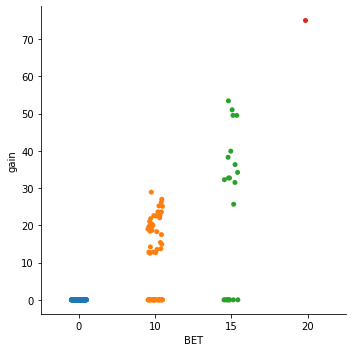

In [ ]:
sns.catplot(x='BET', y='gain', data=df_gains)


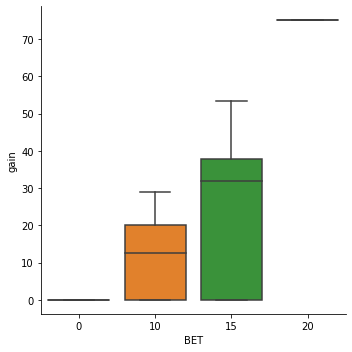

In [ ]:
sns.catplot(x='BET', y='gain', kind='box', data=df_gains);

In [ ]:
fig = px.bar(df_gains, x="pertes", y="BET", color="Prediction")
fig.show()

In [ ]:
fig = px.bar(df_gains, x="pertes", y="BET", color="match")
fig.show()

In [ ]:
st.write(fig = px.bar(df_gains, x="pertes", y="match", color="Prediction"))
st.write(fig.show())

In [ ]:
fig = px.bar(df_gains, x="Prediction", y="pertes", color="match",
             pattern_shape="Prediction", pattern_shape_sequence=[".", "x", "+"])
fig.show()